In [2]:
import pandas as pd
import numpy as np
import random
import warnings
#import time
#import datetime
#import re
#import string
#import itertools
#import pickle
#import joblib
#import nltk
#import csv

from nltk.corpus import stopwords, wordnet

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
#import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
#from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate,Conv1D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
t = Tokenizer()

In [3]:
df_pos = pd.read_excel('train/pos.xlsx')
df_pos["Task"] = df_pos["Task"].str.lower()
df_pos.head()

Unnamed: 0                                               Task  Label  \
0      188052  wind power production tax credit can create gr...      1   
1      169024  animal photos of the week: tigers, capybaras, ...      1   
2      171761  animals playing with toys and gadgets made for...      1   
3      164978  climate change study shows pace is slowing, bu...      1   
4      159807  sea level rise study shows each degree of warm...      1   

                                   short_description  
0  The report said non-construction businesses wo...  
1  Here’s a recap of animal stories and events fr...  
2  We all have a favorite toy, whether it's the l...  
3  The rate of global warming has slowed after st...  
4  "Continuous sea-level rise is something we can...

In [54]:
df_neg = pd.read_excel('train/neg.xlsx')
df_neg["Task"] = df_neg["Task"].str.lower()
df_neg.head()

Unnamed: 0                                               Task  Label  \
0      150019  michelle phan: i don't wash my face in the mor...      0   
1       33736  trump budget would turn more jails into de fac...      0   
2      179606  historic hotels: 21 hotels inducted into histo...      0   
3      114071             north west's persistently trendy style      0   
4      130835           house passes weak response to nsa spying      0   

                                   short_description  
0  On the one beauty product she uses every day.....  
1  Society’s most vulnerable deserve treatment an...  
2  Earlier this week, with the help of Southern L...  
3                                                NaN  
4                                                NaN

In [55]:
df_test = pd.read_csv('test/test.csv')
df_test["Task"] = df_test["Task"].str.lower()
#df_test.head(30)

In [56]:
#Test data config
PositiveTest = list(df_test[df_test['Label'] == 1]['Task'])
negativeTest = list(df_test[df_test['Label'] == 0]['Task'])
df2_val = pd.DataFrame(columns=['text1', 'text2', 'label'])
for data in PositiveTest:
  data1 = data
  data2 = random.choice(PositiveTest)
  data3 = random.choice(negativeTest)

  df2_val.loc[len(df2_val)] = [data1, data2, 1]
  df2_val.loc[len(df2_val)] = [data1, data3, 0]


for data in negativeTest:
  data1 = data
  data2 = random.choice(negativeTest)
  data3 = random.choice(PositiveTest)
  
  df2_val.loc[len(df2_val)] = [data1, data2, 1]
  df2_val.loc[len(df2_val)] = [data1, data3, 0]


In [129]:
def sample_Npos_Nneg(posCount,negCount):
            # Creating pairs of data for siamese training => label 1 if pairs from same class otherwise 0
            positive = list(df_pos[df_pos['Label'] == 1]['Task'])
            negative = list(df_neg[df_neg['Label'] == 0]['Task'])

            df2 = pd.DataFrame(columns=['text1', 'text2', 'label'])
            pos =[]
            for _ in range(posCount):
                  pos.append(random.choice(positive))
            neg = []
            for _ in range(negCount):
                  neg.append(random.choice(negative))
            for data in pos:
                  data2 = random.choice(pos)
                  data1 = random.choice(neg)
                  df2.loc[len(df2)] = [data, data2, 1]
                  df2.loc[len(df2)] = [data1, data2, 0]
            
            for data in neg:
                  data2 = random.choice(neg)
                  data1 = random.choice(pos)
                  df2.loc[len(df2)] = [data, data2, 1]
                  df2.loc[len(df2)] = [data1, data2, 0]

            return df2



In [58]:
def sample_1pos_Nneg(negCount):
            # Creating pairs of data for siamese training => label 1 if pairs from same class otherwise 0
            positive = list(df_pos['Task'])
            negative = list(df_neg['Task'])

            df2 = pd.DataFrame(columns=['text1', 'text2', 'label'])
      
            data1 = random.choice(positive)
            df2.loc[len(df2)] = [data1, data1, 1]
            neg = []
            for _ in range(negCount):
                  neg.append(random.choice(negative))
            for data in neg:
                  data2 = random.choice(neg)
                  df2.loc[len(df2)] = [data, data2, 1]
                  df2.loc[len(df2)] = [data1, data2, 0]
            return df2

In [64]:
X_val = df2_val[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)
t.fit_on_texts(X_val.values)
max_len = 200
X_val['text1'] = df2_val['text1'].astype(str)
X_val['text2'] = df2_val['text2'].astype(str)
val_q1_seq = t.texts_to_sequences(X_val['text1'].values)
val_q2_seq = t.texts_to_sequences(X_val['text2'].values)
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')

In [65]:
def tokeniz(X_train):
        
        #X_train['text1'] = df2['text1'].astype(str)
        #X_train['text2'] = df2['text2'].astype(str)
        
        train_q1_seq = t.texts_to_sequences(X_train['text1'].values)
        train_q2_seq = t.texts_to_sequences(X_train['text2'].values)
        
        train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
        train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
        return train_q1_seq,train_q2_seq


In [68]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [90]:
def build_network(embeddings_index,embedding_matrix,train_q1_seq):

  network = Sequential()
  
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))

  #Hiden layers                     
  network.add(Conv1D(100,64,activation="relu"))
  network.add(MaxPooling1D())
  #network.add(Conv1D(128,32,activation="relu"))

  #network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(64, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'
                    ))
   #outpu layer
  network.add(Dense(1,activation=tf.keras.layers.LeakyReLU(alpha=0.02),
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'
                  ))
                  

  network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network

In [91]:
def modelSet(train_q1_seq,train_q2_seq,embeddings_index,embedding_matrix):
        input_1 = Input(shape=(train_q1_seq.shape[1],))
        input_2 = Input(shape=(train_q2_seq.shape[1],))

        network = build_network(embeddings_index,embedding_matrix,train_q1_seq)

        top = network(input_1)
        bottom = network(input_2)

        distance = Lambda(euclidean_distance)([top, bottom])

        # Connect the inputs with the outputs
        model = Model([input_1, input_2], distance)
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.00001),metrics=['accuracy'])
        return model


In [113]:
totalAccuracy = []

In [ ]:
for nSample in range(1,10):
    accuracyList = []
    for _ in range(10):
        df2 = sample_1pos_Nneg(nSample)
        #X_train = df2[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)
        #https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
        embeddings_index = {}
        f = open('glove.6B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        print('Found %s word vectors.' % len(embeddings_index))
        not_present_list = []
        vocab_size = len(t.word_index) + 1
        print('Loaded %s word vectors.' % len(embeddings_index))
        embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
        for word, i in t.word_index.items():
            if word in embeddings_index.keys():
                embedding_vector = embeddings_index.get(word)
            else:
                not_present_list.append(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                embedding_matrix[i] = np.zeros(300)
        #X_train=X_train.astype("str")

        train_q1_seq,train_q2_seq = tokeniz(df2)
        model=modelSet(train_q1_seq,train_q2_seq,embeddings_index,embedding_matrix)
        y_train = np.asarray(df2["label"]).astype('float32')
        y_val = np.asarray(df2_val['label']).astype('float32')
        hist = model.fit([train_q1_seq,train_q2_seq],y_train.reshape(-1,1), epochs = 10, batch_size=50,validation_data=([val_q1_seq, val_q2_seq],y_val.reshape(-1,1)))
        accuracyList.append(hist.history['val_accuracy'][0])
    totalAccuracy.append(accuracyList)

In [150]:
np.savetxt("values.txt",totalAccuracy)

In [151]:
totalAccuracy = np.loadtxt("values.txt")

In [127]:
avg = []
min_err = []
max_err = []
for i in range(9):
    avg.append(np.average(totalAccuracy[i]))
    min_err.append(avg[i]-np.min(totalAccuracy[i]))
    max_err.append(np.max(totalAccuracy[i])-avg[i])

<ErrorbarContainer object of 3 artists>

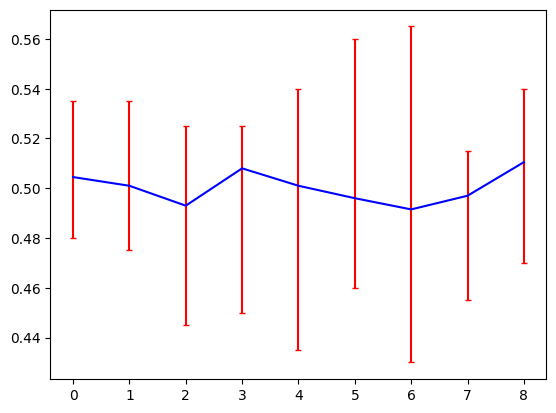

In [128]:
import matplotlib.pyplot as plt
y_err = [min_err,max_err]
plt.errorbar(range(9), avg, yerr=y_err, linestyle='-',ecolor='red', color='blue', capsize=2)

In [131]:
totalAccuracy1 = []

In [ ]:
for nSample in range(1,6):
    accuracyList = []
    nNeg = (nSample+1)**2 - nSample
    for _ in range(10):
        df2 = sample_Npos_Nneg(nSample,nNeg)
        #X_train = df2[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)
        #https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
        embeddings_index = {}
        f = open('glove.6B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        print('Found %s word vectors.' % len(embeddings_index))
        not_present_list = []
        vocab_size = len(t.word_index) + 1
        print('Loaded %s word vectors.' % len(embeddings_index))
        embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
        for word, i in t.word_index.items():
            if word in embeddings_index.keys():
                embedding_vector = embeddings_index.get(word)
            else:
                not_present_list.append(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                embedding_matrix[i] = np.zeros(300)
        #X_train=X_train.astype("str")

        train_q1_seq,train_q2_seq = tokeniz(df2)
        model=modelSet(train_q1_seq,train_q2_seq,embeddings_index,embedding_matrix)
        y_train = np.asarray(df2["label"]).astype('float32')
        y_val = np.asarray(df2_val['label']).astype('float32')
        hist = model.fit([train_q1_seq,train_q2_seq],y_train.reshape(-1,1), epochs = 1, batch_size=50,validation_data=([val_q1_seq, val_q2_seq],y_val.reshape(-1,1)))
        accuracyList.append(hist.history['val_accuracy'][0])
    totalAccuracy1.append(accuracyList)

In [146]:
np.savetxt("valuesN.txt",totalAccuracy1)

In [152]:
totalAccuracy2 = np.loadtxt("valuesN.txt",dtype=np.float64)

In [153]:
avg = []
min_err = []
max_err = []
for i in range(6):
    avg.append(np.average(totalAccuracy2[i]))
    min_err.append(avg[i]-np.min(totalAccuracy2[i]))
    max_err.append(np.max(totalAccuracy2[i])-avg[i])

<ErrorbarContainer object of 3 artists>

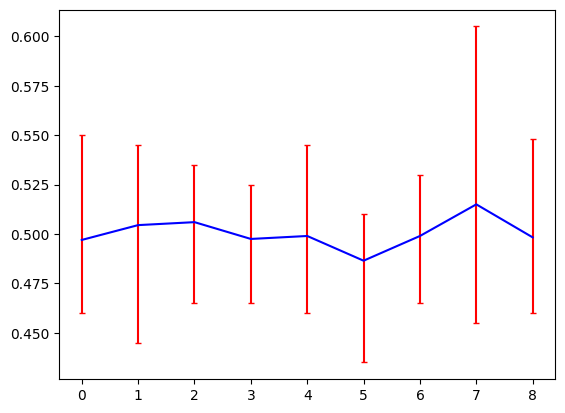

In [154]:
import matplotlib.pyplot as plt
y_err = [min_err,max_err]
plt.errorbar(range(9), avg, yerr=y_err, linestyle='-',ecolor='red', color='blue', capsize=2)